In [58]:
# Transformer
from datasets import load_dataset # to load dataset
from transformers import AutoTokenizer # for tokenization
from transformers import DataCollatorWithPadding # For padding
from transformers import TFAutoModelForSequenceClassification
from pathlib import Path

# kears
from keras.losses import SparseCategoricalCrossentropy
from tensorflow import keras

import matplotlib.pyplot as plt

### ```load_dataset('glue','mrpc')``` Why two?
"glue": This is the name of the dataset group. The "GLUE" (General Language Understanding Evaluation) benchmark is a collection of diverse natural language understanding tasks, and "glue" is the identifier for this collection of datasets.

"mrpc": This is the specific dataset name within the "glue" group. "MRPC" stands for Microsoft Research Paraphrase Corpus, which is one of the tasks in the GLUE benchmark. It is a binary classification task that involves determining whether two sentences are paraphrases of each other or not.

In [2]:
raw_dataset = load_dataset('glue','mrpc')


Found cached dataset glue (C:/Users/Gyanprakash/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [4]:
dataset = raw_dataset['train']
dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

In [5]:
dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [6]:
print(len(dataset))
print(dataset[0])
print(dataset[1])
print(dataset[3667])

3668
{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}
{'sentence1': "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'sentence2': "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .", 'label': 0, 'idx': 1}
{'sentence1': "The 30-year bond US30YT = RR rose 22 / 32 for a yield of 4.31 percent , versus 4.35 percent at Wednesday 's close .", 'sentence2': 'The 30-year bond US30YT = RR grew 1-3 / 32 for a yield of 4.30 percent , down from 4.35 percent late Wednesday .', 'label': 0, 'idx': 4075}


In [7]:
print(len(raw_dataset["train"]["sentence1"]))
raw_dataset["train"]["sentence1"]

3668


['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .',
 'Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .',
 'The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .',
 'The DVD-CCA then appealed to the state Supreme Court .',
 'That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .',
 'Shares of Genentech , a much larger company with several products on the market , rose more than 2 percent .

### Tokenizing


In [8]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_dataset["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_dataset["train"]["sentence2"])

In [9]:
print(tokenized_sentences_1[0])

Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [10]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
print(inputs)
print()
print('here token_type_ids tells the model which part of the input is the first sentence and which is the second sentence. ')

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

here token_type_ids tells the model which part of the input is the first sentence and which is the second sentence. 


In [11]:
inputs["input_ids"][0]

101

#### Decoding the input

In [12]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

In [13]:
len(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))

15

In [14]:
for i in range(0,len(inputs['input_ids'])):
    ids = inputs["input_ids"][i]
    converted_ids = tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    print(ids, converted_ids)

101 [CLS]
2023 this
2003 is
1996 the
2034 first
6251 sentence
1012 .
102 [SEP]
2023 this
2003 is
1996 the
2117 second
2028 one
1012 .
102 [SEP]


In [15]:
for i in range(0,len(inputs['input_ids'])):
    converted_ids = tokenizer.convert_ids_to_tokens(inputs["input_ids"][i])
    token_ids = inputs['token_type_ids'][i]
    print(converted_ids,'- ', token_ids)

[CLS] -  0
this -  0
is -  0
the -  0
first -  0
sentence -  0
. -  0
[SEP] -  0
this -  1
is -  1
the -  1
second -  1
one -  1
. -  1
[SEP] -  1


In [16]:
def tokenize_function(data):
    return tokenizer(data["sentence1"], data["sentence2"], truncation=True)

In [17]:
tokenized_dataset = raw_dataset.map(function=tokenize_function ,batched=True )
tokenized_dataset

Loading cached processed dataset at C:\Users\Gyanprakash\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-eda9c9b12b472eef.arrow


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\Gyanprakash\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-cd713d23926169e8.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf') # Here the tokenizer is referring to  "bert-base-uncased" this checkpoint
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='tf')

In [19]:
samples = tokenized_dataset["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

In [20]:
tokenized_dataset["train"][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0,
 'input_ids': [101,
  2572,
  3217,
  5831,
  5496,
  2010,
  2567,
  1010,
  3183,
  2002,
  2170,
  1000,
  1996,
  7409,
  1000,
  1010,
  1997,
  9969,
  4487,
  23809,
  3436,
  2010,
  3350,
  1012,
  102,
  7727,
  2000,
  2032,
  2004,
  2069,
  1000,
  1996,
  7409,
  1000,
  1010,
  2572,
  3217,
  5831,
  5496,
  2010,
  2567,
  1997,
  9969,
  4487,
  23809,
  3436,
  2010,
  3350,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
 

In [21]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': TensorShape([8, 67]),
 'token_type_ids': TensorShape([8, 67]),
 'attention_mask': TensorShape([8, 67]),
 'labels': TensorShape([8])}

## Training and Validation Data

In [22]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=['labels'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)

c:\Users\Gyanprakash\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [23]:
tf_validation_dataset = tokenized_dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [24]:
tf_train_dataset , tf_validation_dataset

(<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [35]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


#### Defining the learning rate scheduler

In [45]:
batch_size = 8
num_epochs = 3

"""The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
not the original Hugging Face Dataset, so its len() is already num_samples // batch_size."""

num_training_steps = len(tf_train_dataset) * num_epochs

lr_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate= 5e-5,
    end_learning_rate=0.0,
    decay_steps=num_training_steps
)


optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler)

In [49]:
model.compile(
    optimizer = optimizer,
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [50]:
history = model.fit(tf_train_dataset,validation_data = tf_validation_dataset , epochs = 2) 

Epoch 1/2
459/459 [==============================] - 1878s 4s/step - loss: 0.6423 - accuracy: 0.6704 - val_loss: 0.6248 - val_accuracy: 0.6838
Epoch 2/2
459/459 [==============================] - 2374s 5s/step - loss: 0.6402 - accuracy: 0.6734 - val_loss: 0.6240 - val_accuracy: 0.6838


C:\Users\Gyanprakash\AppData\Local\Temp\ipykernel_2324\2890578337.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'val_loss- 0.624 and loss- 0.64')

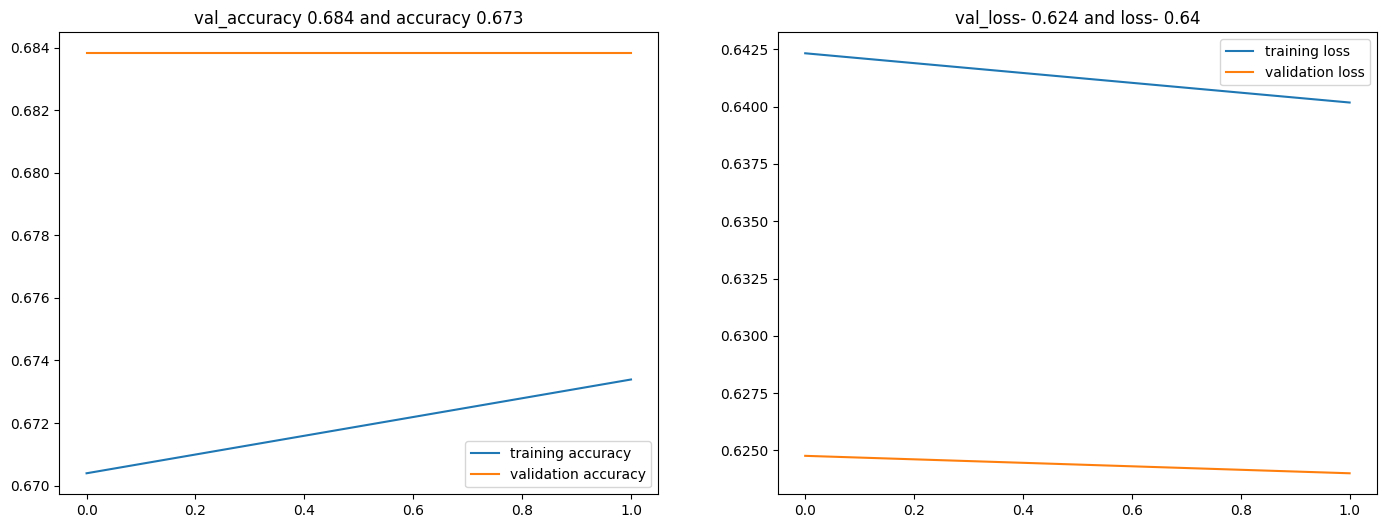

In [62]:
plt.subplots(nrows=1,ncols=1,figsize = (17,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][1],ndigits=3)} and accuracy {round(history.history["accuracy"][1],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][1],ndigits=3)} and loss- {round(history.history["loss"][1],ndigits=3)}')